# Pickup to Delivery Overall

In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances, manhattan_distances
from sklearn.model_selection import train_test_split, cross_val_score

sys.path.insert(0, os.path.expanduser('./'))
import query_runner as qr
import utils

In [2]:
base_query_path = './queries/'
dwh_config, livedb_config, parameters_config = utils.load_config(config_file='./config.ini')
datalake_connection = qr.create_connection(db='datalake')
#monolith_connection = qr.create_connection(user=livedb_config['monolith_username'], password=livedb_config['monolith_password'], db='livedb')
#dispatching_db_connection = qr.create_connection(user=livedb_config['dispatching_db_username'], password=livedb_config['dispatching_db_password'], db='dispatchingdb')

In [3]:
start_date = parameters_config['start_date']
end_date = parameters_config['end_date']
country_code = parameters_config['country_code']
cities = parameters_config['cities']

print(f'Start date: {start_date} | End date: {end_date} | Countries: {country_code} | Cities: {cities}')

Start date: 2024-09-30 | End date: 2024-10-20 | Countries: ES | Cities: 'MAD', 'BCN', 'SEV', 'ALC'


In [4]:
parameters = {
    'start_date': start_date,
    'end_date': end_date,
    'country_code': country_code,
    'cities': cities
}

## Load the data

In [5]:
query_name = '''
SELECT
    olf.country_code                                 AS country_code,
    olf.city_code                                    AS city_code,
    olf.order_id                                     AS order_id,
    olf.courier_id                                   AS courier_id,
    olf.order_created_local_datetime                 AS creation_timestamp,
    olf.order_activated_local_datetime               AS activation_timestamp,
    olf.courier_transport                            AS transport,
    olf.order_pickup_latitude                        AS pickup_latitude,
    olf.order_pickup_longitude                       AS pickup_longitude,
    olf.order_delivery_latitude                      AS delivery_latitude,
    olf.order_delivery_longitude                     AS delivery_longitude,
    olf.order_time_zone                              AS time_zone,
    olf.order_picked_up_local_datetime               AS pickup_timestamp,
    --olf.order_arrival_to_delivery_local_datetime     AS delivery_entering_timestamp,
    olf.order_delivered_local_datetime               AS delivery_timestamp,
    olf.p_creation_date                              AS creation_date
FROM delta.courier_routing_courier_ml_features_odp.order_level_features AS olf
WHERE order_final_status = 'DeliveredStatus'
    AND order_number_of_assignments = 1
    AND order_bundle_index IS NULL
    AND p_creation_date BETWEEN DATE '[start_date]' AND DATE '[end_date]'
    AND country_code IN ('[country_code]')
    AND city_code IN ([cities])
'''

query = qr.Query(base_query_path, query_name, datalake_connection, parameters_dict=parameters, query_from_file = False)
data = query.run()
data = data.fillna(value=np.nan)
data.head()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/88d6e13a4d8f564330b5e61fa4a4757f8d06e65329c51e5563f4a33fee91ad5d


,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,time_zone,pickup_timestamp,delivery_timestamp,creation_date
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,41.370594,2.113433,41.375412,2.104837,Europe/Madrid,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:32:33+00:00,2024-10-03
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,40.382927,-3.626392,40.383490,-3.640969,Europe/Madrid,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:19:10+00:00,2024-10-03
2,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,41.389874,2.159761,41.390520,2.148718,Europe/Madrid,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:14:30+00:00,2024-10-03
3,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,40.409720,-3.670494,40.412880,-3.671840,Europe/Madrid,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:14:21+00:00,2024-10-03
4,ES,MAD,100907503468,166385377,2024-10-03 20:59:51+00:00,2024-10-03 20:59:53+00:00,MOTORBIKE,40.433780,-3.683620,40.430176,-3.673502,Europe/Madrid,2024-10-03 21:09:49.060000+00:00,2024-10-03 21:20:30+00:00,2024-10-03


## Clean the dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043873 entries, 0 to 43872
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype              
---  ------                --------------    -----              
 0   country_code          1043873 non-null  object             
 1   city_code             1043873 non-null  object             
 2   order_id              1043873 non-null  int64              
 3   courier_id            1043873 non-null  int64              
 4   creation_timestamp    1043873 non-null  datetime64[ns, UTC]
 5   activation_timestamp  1043873 non-null  datetime64[ns, UTC]
 6   transport             1043873 non-null  object             
 7   pickup_latitude       1043873 non-null  float64            
 8   pickup_longitude      1043873 non-null  float64            
 9   delivery_latitude     1043873 non-null  float64            
 10  delivery_longitude    1043873 non-null  float64            
 11  time_zone             1043873 non-null  obje

In [7]:
data.describe()

,order_id,courier_id,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude
count,1.043873e+06,1.043873e+06,1.043873e+06,1.043873e+06,1.043873e+06,1.043873e+06
mean,1.009235e+11,1.220252e+08,4.066978e+01,-8.625245e-01,4.067015e+01,-8.624835e-01
std,1.373828e+07,5.587275e+07,9.972123e-01,3.004518e+00,9.973824e-01,3.003922e+00
min,1.008998e+11,1.127770e+05,3.728265e+01,-6.085188e+00,3.726098e+01,-6.100339e+00
25%,1.009113e+11,7.270555e+07,4.042600e+01,-3.690180e+00,4.042608e+01,-3.689568e+00
50%,1.009234e+11,1.484799e+08,4.053028e+01,-4.844410e-01,4.052496e+01,-4.859780e-01
75%,1.009357e+11,1.673414e+08,4.139320e+01,2.159761e+00,4.139475e+01,2.159627e+00
max,1.009470e+11,1.796540e+08,4.148309e+01,2.268973e+00,4.156215e+01,2.277824e+00


In [8]:
# Check for missing values
data.isnull().sum()

country_code              0
city_code                 0
order_id                  0
courier_id                0
creation_timestamp        0
activation_timestamp      0
transport                 0
pickup_latitude           0
pickup_longitude          0
delivery_latitude         0
delivery_longitude        0
time_zone                 0
pickup_timestamp        259
delivery_timestamp        0
creation_date             0
dtype: int64

In [9]:
# print the number of null rows
data.isnull().sum().sum()

np.int64(259)

In [10]:
# Remove rows with null values: we have many rows, so we can afford to remove them
data.dropna(inplace=True)

In [11]:
# Check for missing values
data.isnull().sum()

country_code            0
city_code               0
order_id                0
courier_id              0
creation_timestamp      0
activation_timestamp    0
transport               0
pickup_latitude         0
pickup_longitude        0
delivery_latitude       0
delivery_longitude      0
time_zone               0
pickup_timestamp        0
delivery_timestamp      0
creation_date           0
dtype: int64

In [12]:
# Check for duplicates
data.duplicated().sum()

np.int64(0)

## Compute new features

In [13]:
# Convert the creation time to datetime
data['creation_timestamp'] = pd.to_datetime(data['creation_timestamp'])
data['activation_timestamp'] = pd.to_datetime(data['activation_timestamp'])
data['pickup_timestamp'] = pd.to_datetime(data['pickup_timestamp'])
data['delivery_timestamp'] = pd.to_datetime(data['delivery_timestamp'])

To determine whether a coordinate is in degrees or radians, you can consider the typical ranges and values for latitude and longitude:
1. **Degrees:**
   - Latitude ranges from -90 to 90 degrees.
   - Longitude ranges from -180 to 180 degrees.
   - Values are typically whole numbers or decimals within these ranges.
2. **Radians:**
   - Latitude and longitude in radians will range from approximately -π/2 to π/2 for latitude and -π to π for longitude.
   - Values are typically small decimals (e.g., 0.5, 1.0, etc.).

Given our dataset, as the values in the columns `pickup_latitude`, `pickup_longitude`, `delivery_latitude`, `delivery_longitude` fall within the typical range for degrees, it is safe to assume that these coordinates are in degrees.

There is a difference in how the `haversine` library, the `sklearn`'s `haversine_distances`, and the `sklearn`'s `manhattan_distances` function compute and return the distances. Let's break down the differences and how to resolve them:
1. **Haversine Library:**
   - The `haversine` library directly computes the distance between two points and returns a single scalar value.
2. **Sklearn's `haversine_distances`:**
   - The `haversine_distances` function from `sklearn` returns a distance matrix. When you input two points, it returns a 1x1 matrix (a nested list) containing the distance. This is why you would see the result in squared parentheses like `[[]]`. We extract the single value using `[0][0]`.
   - To use these coordinates with sklearn's `haversine_distances` function, you need to convert them to radians using `np.radians`.
   - Additionally, the `haversine_distances` function returns the distance in radians, not in meters. To convert this to meters, you need to multiply by the Earth's radius (approximately 6371000 meters).
3. **Sklearn's `manhattan_distances`:**
   - The `manhattan_distances` function computes the Manhattan distance between two points and returns a distance matrix. We extract the single value from the 1x1 matrix using `[0][0]`.
   - Additionally, the `manhattan_distances` function from sklearn computes the distance based on the Cartesian coordinates provided. Since latitude and longitude are angular measurements, the result will not be in meters but in degrees. To convert the Manhattan distance from degrees to meters, you need to account for the Earth's curvature. 
      - The conversion factor for latitude is approximately 111,320 meters per degree.
      - The conversion factor for longitude varies based on the latitude. At the equator, it's approximately 111,320 meters per degree, but it decreases as you move towards the poles.
      - Convert the latitude and longitude differences to meters.
      - Sum the absolute differences to get the Manhattan distance in meters.

In [14]:
# Convert degrees to radians
data['pickup_latitude_rad'] = np.radians(data['pickup_latitude'])
data['pickup_longitude_rad'] = np.radians(data['pickup_longitude'])
data['delivery_latitude_rad'] = np.radians(data['delivery_latitude'])
data['delivery_longitude_rad'] = np.radians(data['delivery_longitude'])

# Earth's radius in meters
earth_radius_m = 6371.0088 * 1000  # average earth radius - https://en.wikipedia.org/wiki/Earth_radius#Mean_radius

# Conversion factors
meters_per_degree_lat = 111320  # Approximate meters per degree of latitude

def manhattan_distance_in_meters(row):
    # Convert latitude and longitude differences to meters
    lat_diff_m = abs(row['pickup_latitude'] - row['delivery_latitude']) * meters_per_degree_lat
    # Convert longitude difference to meters, considering the latitude
    lon_diff_m = abs(row['pickup_longitude'] - row['delivery_longitude']) * meters_per_degree_lat * np.cos(np.radians((row['pickup_latitude'] + row['delivery_latitude']) / 2))
    # Sum the absolute differences to get the Manhattan distance in meters
    return lat_diff_m + lon_diff_m

In [15]:
data['pd_distance_haversine_m'] = data.apply(
    lambda x: haversine(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['delivery_latitude'], x['delivery_longitude']),
        unit=Unit.METERS
    ), axis=1
)
data['pd_distance_haversine_m_sk'] = data.apply(
    lambda x: haversine_distances(
        np.array([[x['pickup_latitude_rad'], x['pickup_longitude_rad']]]),
        np.array([[x['delivery_latitude_rad'], x['delivery_longitude_rad']]])
    )[0][0] * earth_radius_m, axis=1
)
data['pd_distance_manhattan_m'] = data.apply(manhattan_distance_in_meters, axis=1)
data.head()

,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,...,pickup_timestamp,delivery_timestamp,creation_date,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,41.370594,2.113433,41.375412,...,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:32:33+00:00,2024-10-03,0.722053,0.036886,0.722137,0.036736,895.267385,895.267385,1254.424177
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,40.382927,-3.626392,40.383490,...,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:19:10+00:00,2024-10-03,0.704815,-0.063292,0.704825,-0.063547,1236.264251,1236.264251,1298.738405
2,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,41.389874,2.159761,41.390520,...,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:14:30+00:00,2024-10-03,0.722390,0.037695,0.722401,0.037502,924.017061,924.017061,994.168407
3,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,40.409720,-3.670494,40.412880,...,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:14:21+00:00,2024-10-03,0.705283,-0.064062,0.705338,-0.064086,369.394256,369.394256,465.858447
4,ES,MAD,100907503468,166385377,2024-10-03 20:59:51+00:00,2024-10-03 20:59:53+00:00,MOTORBIKE,40.433780,-3.683620,40.430176,...,2024-10-03 21:09:49.060000+00:00,2024-10-03 21:20:30+00:00,2024-10-03,0.705703,-0.064291,0.705640,-0.064115,945.506113,945.506113,1258.537546


In [16]:
# print the number of null rows
data.isnull().sum().sum()

np.int64(0)

## Save the dataset

It's better to use the parquet format, as it is more efficient and faster to read and write. Besides, it is a columnar format, which is more suitable for analytical queries. We can also partition the data by creation date and city, which will help to speed up the queries and allows to analyze different timeframes and different cities if needed.

In [17]:
# parquet appends the data in the files, it doesn't overwrite them, so we need to manually remove the folder with its content to avoid duplicated data
shutil.rmtree("data/parquet/")
os.makedirs("data/parquet/")

In [18]:
data.to_parquet("data/parquet/dataframe.parquet", index=False, partition_cols=['creation_date', 'city_code'])

## Load the dataset

In [19]:
data = pd.read_parquet("data/parquet/dataframe.parquet")

## Exploratory Data Analysis (EDA)

In [20]:
# Compute the delivery date and the delivery time
data['activation_time'] = data['activation_timestamp'].dt.time
data['activation_hour'] = data['activation_timestamp'].dt.hour

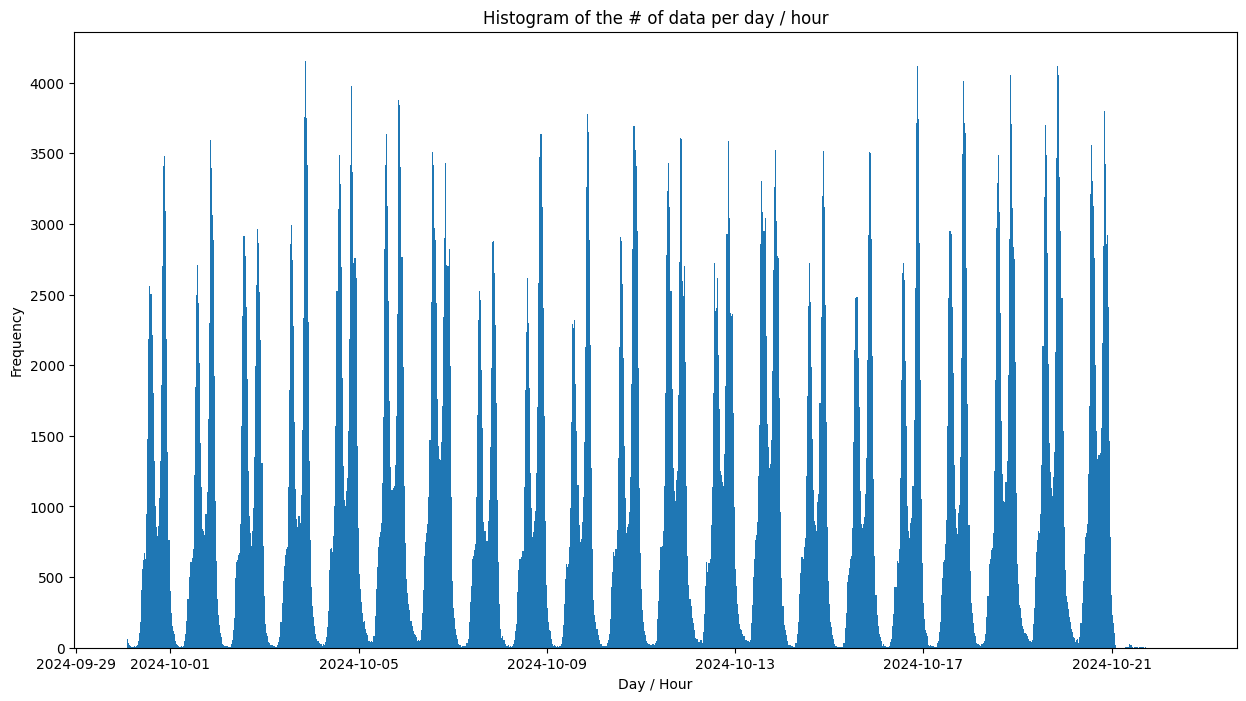

In [21]:
# Histogram of the # of data per day / hour
plt.figure(figsize=(15, 8))
plt.hist(data['activation_timestamp'], bins = 1000)
plt.title('Histogram of the # of data per day / hour')
plt.xlabel('Day / Hour')
plt.ylabel('Frequency')
plt.show()

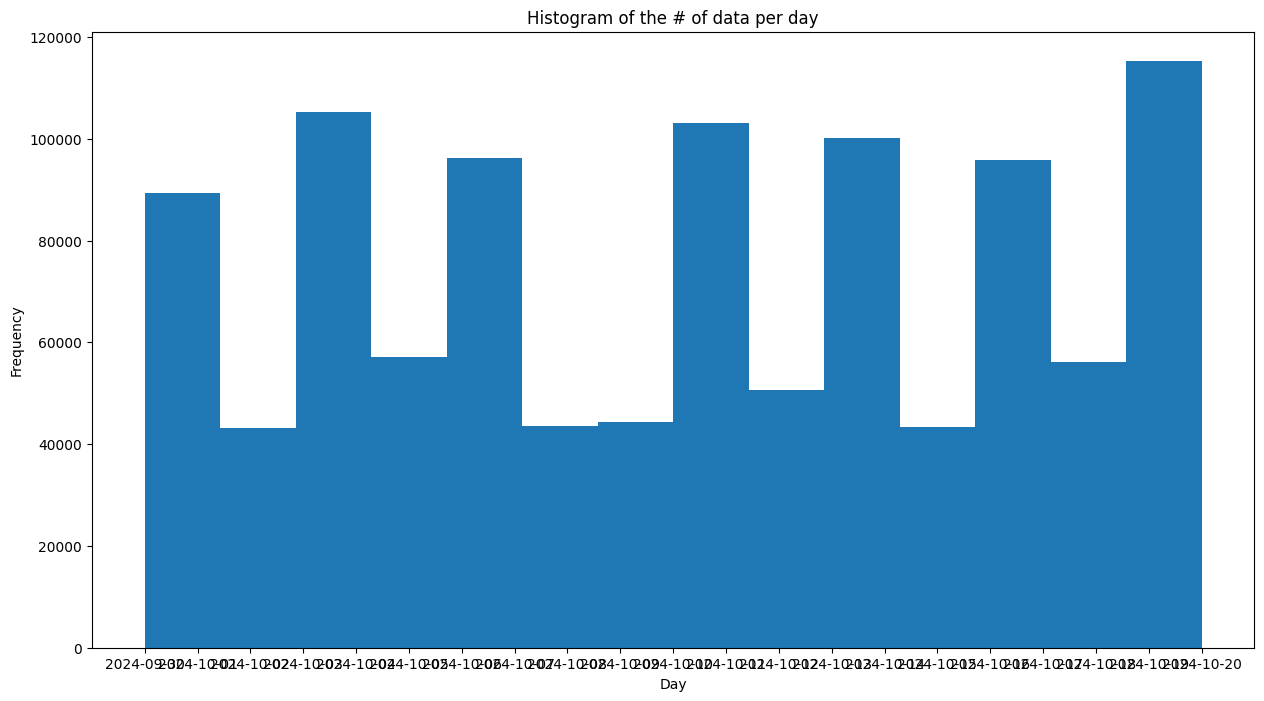

In [22]:
plt.figure(figsize=(15, 8))
plt.hist(data['creation_date'], bins = 14)
plt.title('Histogram of the # of data per day')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()

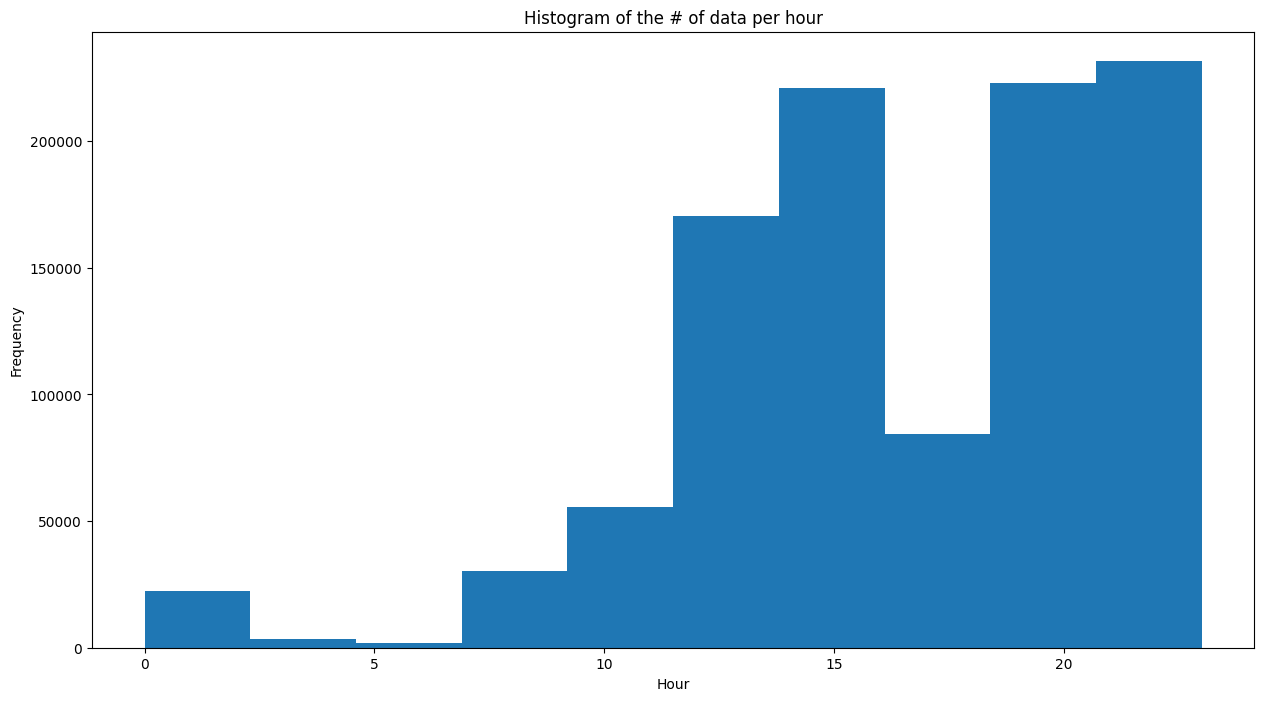

In [23]:
plt.figure(figsize=(15, 8))
plt.hist(data['activation_hour'])
plt.title('Histogram of the # of data per hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Check the distribution of the transport types
data['transport'].value_counts()

transport
BICYCLE      494403
MOTORBIKE    422782
CAR          125909
WALKER          520
Name: count, dtype: int64

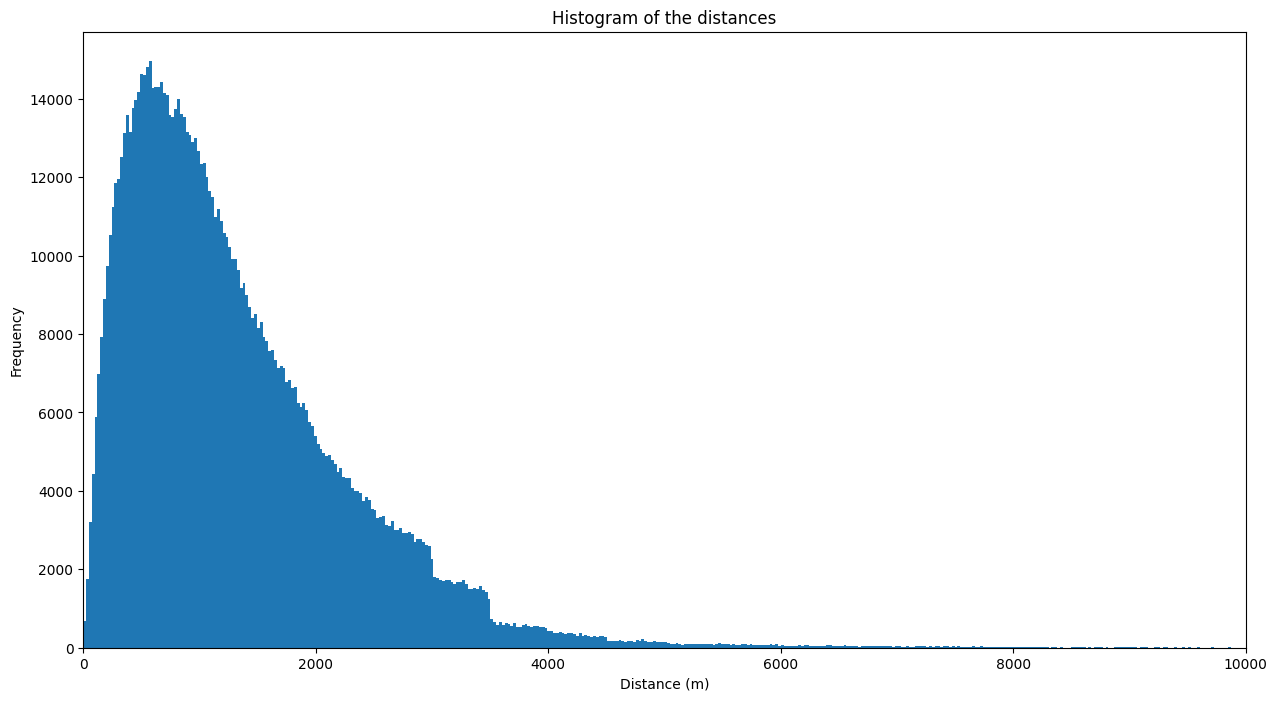

In [25]:
# Check the distribution of the distances
plt.figure(figsize=(15, 8))
plt.hist(data['pd_distance_haversine_m'], bins = 1000)
plt.xlim(0, 10000)
plt.title('Histogram of the distances')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.show()

## Hyperparameters

In [26]:
test_set_perc = 0.1
days_for_test = 7
k_cv = 5

## Database split

In [27]:
train_columns = ['country_code', 'city_code', 'order_id', 'courier_id', 'activation_timestamp', 'transport', 'pickup_latitude', 'pickup_longitude',
                 'delivery_latitude', 'delivery_longitude', 'time_zone', 'pickup_latitude_rad', 'pickup_longitude_rad', 'delivery_latitude_rad',
                 'delivery_longitude_rad', 'pd_distance_haversine_m', 'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m']
X = data[train_columns].copy()
y = (data['delivery_timestamp'] - data['pickup_timestamp']).dt.total_seconds()
y = pd.Series(y, name='pickup_to_delivery')
y

0          564.308
1          464.860
2          511.029
3          906.377
4          680.043
            ...   
1043609    859.357
1043610    505.484
1043611    436.882
1043612    517.377
1043613    691.325
Name: pickup_to_delivery, Length: 1043614, dtype: float64

As we are dealing with a time-series dataset (orders are placed at different times), we will split the data based on the creation timestamp, leaving out the last 10% of the data for testing. This will help to understand the performance of the model on unseen data, as in reality we will have to test the model on data created on day+1 with respect to our training data.

In [28]:
X.sort_values('activation_timestamp', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_perc, random_state=0)

In [29]:
X_train

,country_code,city_code,order_id,courier_id,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,time_zone,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
216013,ES,MAD,100908272495,163418145,2024-10-04 12:25:46+00:00,MOTORBIKE,40.422318,-3.694224,40.429104,-3.691762,Europe/Madrid,0.705503,-0.064476,0.705621,-0.064433,782.819589,782.819589,964.052471
695901,ES,BCN,100932710896,176234210,2024-10-14 19:47:26+00:00,BICYCLE,41.376660,2.172004,41.381382,2.179668,Europe/Madrid,0.722159,0.037909,0.722241,0.038042,827.398330,827.398330,1165.821701
738936,ES,BCN,100933683469,132387012,2024-10-15 13:06:01+00:00,MOTORBIKE,41.391770,2.180567,41.393860,2.193024,Europe/Madrid,0.722423,0.038058,0.722459,0.038275,1064.806772,1064.806772,1272.962743
852314,ES,MAD,100938972716,160582199,2024-10-17 20:48:37+00:00,MOTORBIKE,40.403374,-3.637724,40.397865,-3.641072,Europe/Madrid,0.705172,-0.063490,0.705076,-0.063549,674.996963,674.996963,897.084108
761588,ES,MAD,100933362982,56735057,2024-10-15 09:50:27+00:00,CAR,40.476870,-3.688909,40.471684,-3.696338,Europe/Madrid,0.706455,-0.064384,0.706364,-0.064513,852.880759,852.880759,1206.399489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944683,ES,BCN,100943588467,27190542,2024-10-19 19:54:46+00:00,MOTORBIKE,41.358780,2.140459,41.355995,2.142461,Europe/Madrid,0.721847,0.037358,0.721798,0.037393,351.881959,351.881959,477.307499
98134,ES,BCN,100905215098,84811393,2024-10-02 20:04:06+00:00,MOTORBIKE,41.388477,2.173136,41.392323,2.186695,Europe/Madrid,0.722365,0.037928,0.722432,0.038165,1209.251244,1209.251244,1560.512507
452363,ES,BCN,100919556253,177355697,2024-10-09 09:43:00+00:00,BICYCLE,41.403890,2.197596,41.397816,2.201170,Europe/Madrid,0.722634,0.038355,0.722528,0.038418,738.259099,738.259099,974.591213
340286,ES,MAD,100913456263,148739564,2024-10-06 13:20:02+00:00,BICYCLE,40.416176,-3.700308,40.411835,-3.702255,Europe/Madrid,0.705395,-0.064583,0.705320,-0.064617,510.066878,510.066878,648.261621


In [30]:
y_train

187877    690.484
715461    514.653
739654    513.563
857768    423.692
734084    567.248
           ...   
963395    633.350
117952    911.744
435829    346.596
305711    147.967
985772    654.098
Name: pickup_to_delivery, Length: 939252, dtype: float64

In [31]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(939252, 18) (939252,)
(104362, 18) (104362,)


In [32]:
# In case we want to test different hyperparameters, we will use cross-validation
#scores = cross_val_score(<estimator>, X, y, cv=k_cv)

### Database split using directly the creation date

As we have partitioned the data by city and creation date, we can use this information to split the data. This will help to avoid data leakage, as we will not have data from the future in the training set.
This is much better than just sorting the data by the creation timestamp and taking 10% of the dataset as test set, as we did before.

In [33]:
# We take the last week of the dataset to test the model
begin_test_date = pd.to_datetime(end_date) - pd.Timedelta(days=days_for_test-1)
begin_test_date = begin_test_date.strftime("%Y-%m-%d")
print(f'Start date: {start_date} | Begin test date: {begin_test_date} | End date: {end_date}')

Start date: 2024-09-30 | Begin test date: 2024-10-14 | End date: 2024-10-20


In [34]:
data_train = pd.read_parquet("data/parquet/dataframe.parquet/", filters=[('creation_date', '<', begin_test_date)])
data_train.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_timestamp,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
0,ES,100901465337,169809943,2024-09-30 21:45:07+00:00,2024-09-30 21:45:08+00:00,MOTORBIKE,38.363853,-0.490179,38.384950,-0.492624,...,2024-09-30 22:10:01+00:00,0.669576,-0.008555,0.669944,-0.008598,2355.545318,2355.545318,2561.897200,2024-09-30,ALC
1,ES,100901489101,9516729,2024-09-30 21:55:46+00:00,2024-09-30 21:55:47+00:00,CAR,38.367390,-0.424259,38.364704,-0.417333,...,2024-09-30 22:09:18+00:00,0.669637,-0.007405,0.669590,-0.007284,673.661802,673.661802,903.518684,2024-09-30,ALC
2,ES,100899913152,172855743,2024-09-30 10:30:55+00:00,2024-09-30 10:30:57+00:00,MOTORBIKE,38.345226,-0.492212,38.345290,-0.485164,...,2024-09-30 10:49:56+00:00,0.669250,-0.008591,0.669252,-0.008468,614.688869,614.688869,622.462666,2024-09-30,ALC
3,ES,100900447439,170201413,2024-09-30 14:46:15+00:00,2024-09-30 14:46:16+00:00,CAR,38.365310,-0.469368,38.361786,-0.435688,...,2024-09-30 15:11:36+00:00,0.669601,-0.008192,0.669539,-0.007604,2962.480499,2962.480499,3332.041363,2024-09-30,ALC
4,ES,100900529830,176424631,2024-09-30 15:22:32+00:00,2024-09-30 15:22:33+00:00,MOTORBIKE,38.345670,-0.484130,38.345665,-0.503724,...,2024-09-30 15:56:07+00:00,0.669258,-0.008450,0.669258,-0.008792,1708.759794,1708.759794,1711.235976,2024-09-30,ALC


In [35]:
train_columns = ['country_code', 'city_code', 'order_id', 'courier_id', 'activation_timestamp', 'transport', 'pickup_latitude', 'pickup_longitude',
                 'delivery_latitude', 'delivery_longitude', 'time_zone', 'pickup_latitude_rad', 'pickup_longitude_rad', 'delivery_latitude_rad',
                 'delivery_longitude_rad', 'pd_distance_haversine_m', 'pd_distance_haversine_m_sk', 'pd_distance_manhattan_m']
X_train = data_train[train_columns].copy()
X_train.head()

,country_code,city_code,order_id,courier_id,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,time_zone,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,ALC,100901465337,169809943,2024-09-30 21:45:08+00:00,MOTORBIKE,38.363853,-0.490179,38.384950,-0.492624,Europe/Madrid,0.669576,-0.008555,0.669944,-0.008598,2355.545318,2355.545318,2561.897200
1,ES,ALC,100901489101,9516729,2024-09-30 21:55:47+00:00,CAR,38.367390,-0.424259,38.364704,-0.417333,Europe/Madrid,0.669637,-0.007405,0.669590,-0.007284,673.661802,673.661802,903.518684
2,ES,ALC,100899913152,172855743,2024-09-30 10:30:57+00:00,MOTORBIKE,38.345226,-0.492212,38.345290,-0.485164,Europe/Madrid,0.669250,-0.008591,0.669252,-0.008468,614.688869,614.688869,622.462666
3,ES,ALC,100900447439,170201413,2024-09-30 14:46:16+00:00,CAR,38.365310,-0.469368,38.361786,-0.435688,Europe/Madrid,0.669601,-0.008192,0.669539,-0.007604,2962.480499,2962.480499,3332.041363
4,ES,ALC,100900529830,176424631,2024-09-30 15:22:33+00:00,MOTORBIKE,38.345670,-0.484130,38.345665,-0.503724,Europe/Madrid,0.669258,-0.008450,0.669258,-0.008792,1708.759794,1708.759794,1711.235976


In [36]:
# Check that there are no nulls deriving from a wrong writing of parquet files (appending instead of overwriting)
X_train.isnull().sum().sum()

np.int64(0)

In [37]:
y_train = (data_train['delivery_timestamp'] - data_train['pickup_timestamp']).dt.total_seconds()
y_train = pd.Series(y_train, name='pickup_to_delivery')
y_train

0         564.308
1         464.860
2         511.029
3         906.377
4         680.043
           ...   
688810    600.971
688811    270.726
688812    244.485
688813    605.772
688814    529.026
Name: pickup_to_delivery, Length: 688815, dtype: float64

In [38]:
y_train.isnull().sum().sum()

np.int64(0)

In [39]:
data_test = pd.read_parquet("data/parquet/dataframe.parquet", filters=[('creation_date', '>=', begin_test_date)])
data_test.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,...,delivery_timestamp,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
0,ES,100933187613,176241347,2024-10-14 23:24:53+00:00,2024-10-14 23:24:54+00:00,BICYCLE,38.345078,-0.483469,38.349590,-0.487954,...,2024-10-14 23:45:58+00:00,0.669248,-0.008438,0.669327,-0.008516,636.152666,636.152666,893.835525,2024-10-14,ALC
1,ES,100933198445,10191824,2024-10-14 23:37:45+00:00,2024-10-14 23:37:46+00:00,MOTORBIKE,38.345078,-0.483469,38.342422,-0.491674,...,2024-10-15 00:04:30+00:00,0.669248,-0.008438,0.669202,-0.008581,774.114259,774.114259,1012.032964,2024-10-14,ALC
2,ES,100931749423,169099229,2024-10-14 12:57:37+00:00,2024-10-14 12:57:38+00:00,CAR,38.361095,-0.494881,38.341293,-0.493355,...,2024-10-14 13:22:05+00:00,0.669527,-0.008637,0.669182,-0.008611,2205.902313,2205.902313,2337.577867,2024-10-14,ALC
3,ES,100931867858,177428955,2024-10-14 13:44:05+00:00,2024-10-14 13:44:06+00:00,BICYCLE,38.354984,-0.470788,38.341026,-0.495109,...,2024-10-14 14:26:28+00:00,0.669421,-0.008217,0.669177,-0.008641,2628.158235,2628.158235,3677.112224,2024-10-14,ALC
4,ES,100931917343,3548605,2024-10-14 14:03:19+00:00,2024-10-14 14:03:20+00:00,CAR,38.349670,-0.486936,38.346386,-0.493532,...,2024-10-14 14:28:00+00:00,0.669328,-0.008499,0.669271,-0.008614,681.328589,681.328589,941.428377,2024-10-14,ALC


In [40]:
X_test = data_test[train_columns].copy()
X_test.head()

,country_code,city_code,order_id,courier_id,activation_timestamp,transport,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,time_zone,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,ALC,100933187613,176241347,2024-10-14 23:24:54+00:00,BICYCLE,38.345078,-0.483469,38.349590,-0.487954,Europe/Madrid,0.669248,-0.008438,0.669327,-0.008516,636.152666,636.152666,893.835525
1,ES,ALC,100933198445,10191824,2024-10-14 23:37:46+00:00,MOTORBIKE,38.345078,-0.483469,38.342422,-0.491674,Europe/Madrid,0.669248,-0.008438,0.669202,-0.008581,774.114259,774.114259,1012.032964
2,ES,ALC,100931749423,169099229,2024-10-14 12:57:38+00:00,CAR,38.361095,-0.494881,38.341293,-0.493355,Europe/Madrid,0.669527,-0.008637,0.669182,-0.008611,2205.902313,2205.902313,2337.577867
3,ES,ALC,100931867858,177428955,2024-10-14 13:44:06+00:00,BICYCLE,38.354984,-0.470788,38.341026,-0.495109,Europe/Madrid,0.669421,-0.008217,0.669177,-0.008641,2628.158235,2628.158235,3677.112224
4,ES,ALC,100931917343,3548605,2024-10-14 14:03:20+00:00,CAR,38.349670,-0.486936,38.346386,-0.493532,Europe/Madrid,0.669328,-0.008499,0.669271,-0.008614,681.328589,681.328589,941.428377


In [41]:
X_test.isnull().sum().sum()

np.int64(0)

To compute the MAE, we need to do a power to 2, but if I use the type `np.timedelta64(1, "ns")` for `y_test` I get the following error:
`TypeError: cannot perform __pow__ with this index type: TimedeltaArray`
Therefore we will use the type `np.float64` for `y_test`.

In [42]:
y_test = (data_test['delivery_timestamp'] - data_test['pickup_timestamp']).dt.total_seconds()
y_test = pd.Series(y_test, dtype=np.float64, name='pickup_to_delivery')
y_test

0          319.677
1          811.649
2          614.700
3         1111.154
4          806.566
            ...   
354794     859.357
354795     505.484
354796     436.882
354797     517.377
354798     691.325
Name: pickup_to_delivery, Length: 354799, dtype: float64

In [43]:
y_test.isnull().sum().sum()

np.int64(0)

In [44]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(688815, 18) (688815,)
(354799, 18) (354799,)
